In [2]:
import os
import shutil
from pathlib import Path
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
origem = Path('animais')
treino = Path('animais/treino')
validacao = Path('animais/validacao')
teste = Path('animais/teste')
classes = ['WhalesDataset', 'ButterflyDataset', 'DogDataset']

In [4]:
# --- Separação das imagens em treino e validação ---
# --- Separação das imagens em treino, validação e teste em uma nova pasta ---
base_destino = Path('dataset_organizado')
treino = base_destino / 'treino'
validacao = base_destino / 'validacao'
teste = base_destino / 'teste'

for classe in classes:
    arquivos = sorted(os.listdir(origem / classe))
    n = len(arquivos)
    n_treino = int(0.7 * n)
    n_valid = int(0.15 * n)
    n_teste = n - n_treino - n_valid

    for split, start, end in [
        (treino, 0, n_treino),
        (validacao, n_treino, n_treino + n_valid),
        (teste, n_treino + n_valid, n)
    ]:
        (split / classe).mkdir(parents=True, exist_ok=True)
        for arquivo in arquivos[start:end]:
            shutil.copy(origem / classe / arquivo, split / classe / arquivo)

In [13]:
# --- Data Augmentation apenas no treino, cópia simples para validação e teste ---
base_aumentado = Path('dataset_aumentado')
aug_treino = base_aumentado / 'treino'
aug_validacao = base_aumentado / 'validacao'
aug_teste = base_aumentado / 'teste'

datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
img_size = (150, 150)
aug_treino.mkdir(parents=True, exist_ok=True)
aug_validacao.mkdir(parents=True, exist_ok=True)
aug_teste.mkdir(parents=True, exist_ok=True)

# Augmentation no treino
for classe in classes:
    input_path = treino / classe
    output_path = aug_treino / classe
    output_path.mkdir(parents=True, exist_ok=True)
    for img_file in os.listdir(input_path):
        img_path = input_path / img_file
        img = load_img(img_path, target_size=img_size)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_path, save_prefix=classe, save_format='jpeg'):
            i += 1
            if i >= 5:  # 10 aumentadas por imagem
                break

# Cópia simples para validação e teste
for split, origem_split, destino_split in [
    ('validacao', validacao, aug_validacao),
    ('teste', teste, aug_teste)
]:
    for classe in classes:
        input_path = origem_split / classe
        output_path = destino_split / classe
        output_path.mkdir(parents=True, exist_ok=True)
        for img_file in os.listdir(input_path):
            shutil.copy(input_path / img_file, output_path / img_file)

FileNotFoundError: [Errno 2] No such file or directory: 'animais/treino/WhalesDataset'

## Random Forest

In [4]:
img_size = (150, 150)

def carregar_dados(pasta, classes, img_size):
    X, y = [], []
    for label, classe in enumerate(classes):
        for arquivo in os.listdir(pasta / classe):
            caminho_img = pasta / classe / arquivo
            try:
                img = load_img(caminho_img, target_size=img_size)
                img_array = img_to_array(img).flatten() / 255.0
                X.append(img_array)
                y.append(label)
            except:
                pass
    return np.array(X), np.array(y)

X_train, y_train = carregar_dados(aug_treino, classes, img_size)
X_val, y_val = carregar_dados(validacao, classes, img_size)
X_test, y_test = carregar_dados(teste, classes, img_size)

NameError: name 'aug_treino' is not defined

In [5]:
from pathlib import Path
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Definir os caminhos das pastas
base_aumentado = Path('dataset_aumentado')
base_destino = Path('dataset_organizado')

aug_treino = base_aumentado / 'treino'        
validacao = base_destino / 'validacao'        
teste = base_destino / 'teste'                

classes = ['WhalesDataset', 'ButterflyDataset', 'DogDataset']
img_size = (150, 150)

# Função para carregar dados
def carregar_dados(pasta, classes, img_size):
    X, y = [], []
    for label, classe in enumerate(classes):
        pasta_classe = pasta / classe
        if pasta_classe.exists():
            for arquivo in os.listdir(pasta_classe):
                caminho_img = pasta_classe / arquivo
                try:
                    img = load_img(caminho_img, target_size=img_size)
                    img_array = img_to_array(img).flatten() / 255.0
                    X.append(img_array)
                    y.append(label)
                except:
                    pass
        else:
            print(f"⚠️  Pasta não encontrada: {pasta_classe}")
    return np.array(X), np.array(y)

# Carregar os dados
print("Carregando dados...")
X_train, y_train = carregar_dados(aug_treino, classes, img_size)
X_val, y_val = carregar_dados(validacao, classes, img_size)
X_test, y_test = carregar_dados(teste, classes, img_size)

print(f"\nDados carregados:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

Carregando dados...

Dados carregados:
X_train: (5344, 67500)
X_val: (252, 67500)
X_test: (258, 67500)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np
import joblib 

n_runs = 15
accs_rf = []
f1s_rf = []
recalls_rf = []
precisions_rf = []
best_acc_rf = 0
best_model_rf = None

for i in range(n_runs):
    clf = RandomForestClassifier(n_estimators=100, random_state=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accs_rf.append(acc)
    f1s_rf.append(f1_score(y_test, y_pred, average='weighted'))
    recalls_rf.append(recall_score(y_test, y_pred, average='weighted'))
    precisions_rf.append(precision_score(y_test, y_pred, average='weighted'))
    if acc > best_acc_rf:
        best_acc_rf = acc
        best_model_rf = clf

joblib.dump(best_model_rf, "random_forest_melhor_modelo.joblib")

print("Acurácia média:", np.mean(accs_rf))
print("F1-score médio:", np.mean(f1s_rf))
print("Recall médio:", np.mean(recalls_rf))
print("Precision média:", np.mean(precisions_rf))
print("Melhor acurácia:", best_acc_rf)
print("Modelo salvo como random_forest_melhor_modelo.joblib")

Acurácia média: 0.7640826873385014
F1-score médio: 0.7641968926929757
Recall médio: 0.7640826873385014
Precision média: 0.7765425617393809
Melhor acurácia: 0.7829457364341085
Modelo salvo como random_forest_melhor_modelo.joblib


Random Forest (Melhor Modelo):
                  precision    recall  f1-score   support

   WhalesDataset       0.99      0.94      0.96        86
ButterflyDataset       0.77      0.58      0.66        86
      DogDataset       0.64      0.83      0.72        86

        accuracy                           0.78       258
       macro avg       0.80      0.78      0.78       258
    weighted avg       0.80      0.78      0.78       258

Acurácia: 0.7829457364341085
F1-score: 0.7824498508853234
Recall: 0.7829457364341085
Precision: 0.7988917623063966


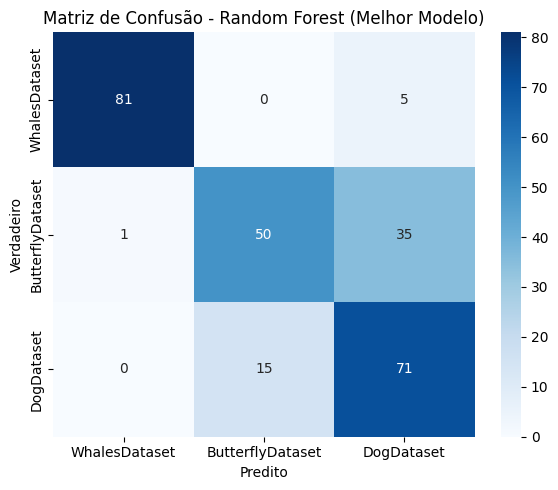

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred_best = best_model_rf.predict(X_test)

print("Random Forest (Melhor Modelo):")
print(classification_report(y_test, y_pred_best, target_names=classes))
print("Acurácia:", accuracy_score(y_test, y_pred_best))
print("F1-score:", f1_score(y_test, y_pred_best, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_best, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_best, average='weighted'))

cm_rf = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Random Forest (Melhor Modelo)')
plt.tight_layout()
plt.show()

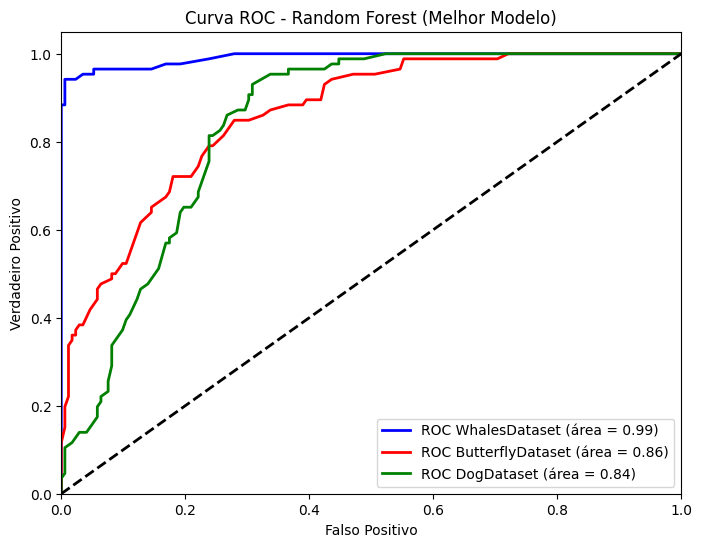

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# --- Random Forest ROC (usando o melhor modelo) ---
y_test_bin = label_binarize(y_test, classes=range(len(classes)))
if hasattr(best_model_rf, "predict_proba"):
    y_score_rf = best_model_rf.predict_proba(X_test)
else:
    y_score_rf = best_model_rf.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {classes[i]} (área = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC - Random Forest (Melhor Modelo)')
plt.legend(loc="lower right")
plt.show()

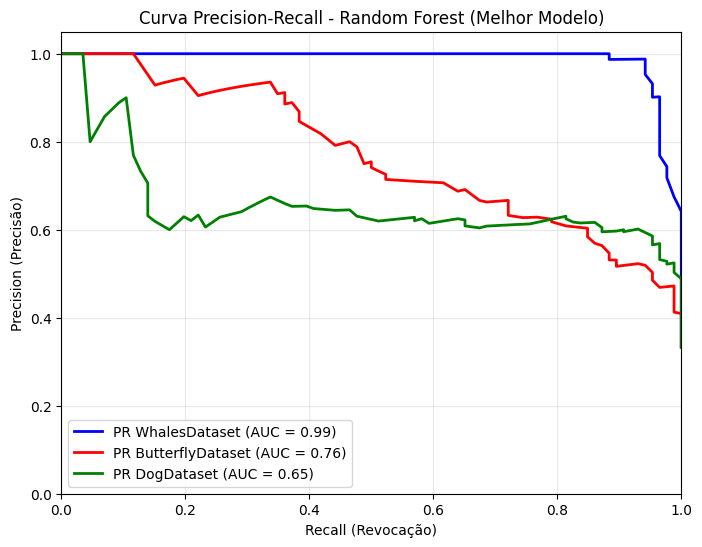


Área sob a curva Precision-Recall (AUC-PR):
WhalesDataset: 0.9864
ButterflyDataset: 0.7639
DogDataset: 0.6545


In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# Fazer predições para Random Forest
y_pred_best_rf = best_model_rf.predict(X_test)
y_score_rf = best_model_rf.predict_proba(X_test)  # Probabilidades para cada classe

# Binarizar os labels verdadeiros
y_true_rf_bin = label_binarize(y_test, classes=range(len(classes)))

# Calcular Precision-Recall para cada classe
precision_rf = dict()
recall_rf = dict()
pr_auc_rf = dict()

for i in range(len(classes)):
    precision_rf[i], recall_rf[i], _ = precision_recall_curve(y_true_rf_bin[:, i], y_score_rf[:, i])
    pr_auc_rf[i] = average_precision_score(y_true_rf_bin[:, i], y_score_rf[:, i])

# Plotar a curva Precision-Recall
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(recall_rf[i], precision_rf[i], color=color, lw=2,
             label=f'PR {classes[i]} (AUC = {pr_auc_rf[i]:0.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Revocação)')
plt.ylabel('Precision (Precisão)')
plt.title('Curva Precision-Recall - Random Forest (Melhor Modelo)')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

# Mostrar os valores AUC-PR
print("\nÁrea sob a curva Precision-Recall (AUC-PR):")
for i, classe in enumerate(classes):
    print(f"{classe}: {pr_auc_rf[i]:.4f}")

## MobileNetV2

In [10]:
# Redefinir os caminhos para as pastas já existentes
from pathlib import Path

base_aumentado = Path('dataset_aumentado')
aug_treino = base_aumentado / 'treino'
aug_validacao = base_aumentado / 'validacao'
aug_teste = base_aumentado / 'teste'

# Verificar se as pastas existem
img_size = (150, 150)
print(f"Pasta treino existe: {aug_treino.exists()}")
print(f"Pasta validação existe: {aug_validacao.exists()}")
print(f"Pasta teste existe: {aug_teste.exists()}")

# Agora o código do MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np

n_runs = 15
accs = []
f1s = []
recalls = []
precisions = []
best_acc = 0
best_model = None

# Aplicar apenas o preprocess_input (sem data augmentation adicional)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 32

train_gen = train_datagen.flow_from_directory(
    str(aug_treino),
    target_size=img_size,
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    str(aug_validacao), 
    target_size=img_size,
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    str(aug_teste), 
    target_size=img_size,
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

for i in range(n_runs):
    print(f"\n=== Run {i+1}/{n_runs} ===")
    
    # Modelo MUITO mais conservador
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    
    # Congelar TODAS as camadas (apenas extração de features)
    for layer in base_model.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.8)(x)  # Dropout muito alto
    x = Dense(32, activation='relu')(x)  # Camada muito pequena
    x = Dropout(0.6)(x)  # Dropout alto
    output = Dense(len(classes), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=0.00001),  # LR extremamente baixo
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_gen,
        epochs=3,  # Apenas 3 épocas
        validation_data=val_gen,
        verbose=1
    )
    
    y_pred_mobilenet = model.predict(test_gen, verbose=0)
    y_pred_mobilenet_labels = np.argmax(y_pred_mobilenet, axis=1)
    y_true_mobilenet = test_gen.classes
    
    acc = accuracy_score(y_true_mobilenet, y_pred_mobilenet_labels)
    accs.append(acc)
    f1s.append(f1_score(y_true_mobilenet, y_pred_mobilenet_labels, average='weighted'))
    recalls.append(recall_score(y_true_mobilenet, y_pred_mobilenet_labels, average='weighted'))
    precisions.append(precision_score(y_true_mobilenet, y_pred_mobilenet_labels, average='weighted'))
    
    if acc > best_acc:
        best_acc = acc
        best_model = model
    
    print(f"Acurácia do Run {i+1}: {acc:.4f}")

print(f"\nResultados após {n_runs} execuções:")
print(f"Acurácia média: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"F1-score médio: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"Recall médio: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"Precision média: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Melhor acurácia: {best_acc:.4f}")

Pasta treino existe: True
Pasta validação existe: True
Pasta teste existe: True
Found 5344 images belonging to 3 classes.
Found 252 images belonging to 3 classes.
Found 258 images belonging to 3 classes.

=== Run 1/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3


/home/jullia/miniconda3/envs/avanti/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 51s 284ms/step - accuracy: 0.3366 - loss: 4.1656 - val_accuracy: 0.4206 - val_loss: 1.3655
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 47s 279ms/step - accuracy: 0.3623 - loss: 3.7941 - val_accuracy: 0.4841 - val_loss: 1.1690
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 46s 276ms/step - accuracy: 0.3660 - loss: 3.4977 - val_accuracy: 0.5595 - val_loss: 1.0250
Acurácia do Run 1: 0.5814

=== Run 2/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 49s 280ms/step - accuracy: 0.3133 - loss: 5.0700 - val_accuracy: 0.3452 - val_loss: 1.4890
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 48s 287ms/step - accuracy: 0.3148 - loss: 4.3423 - val_accuracy: 0.4087 - val_loss: 1.1357
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 46s 273ms/step - accuracy: 0.3376 - loss: 3.7339 - val_accuracy: 0.5159 - val_loss: 0.9615
Acurácia do Run 2: 0.5271

=== Run 3/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 42s 234ms/step - accuracy: 0.3404 - loss: 4.0140 - val_accuracy: 0.3889 - val_loss: 1.2534
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.3731 - loss: 3.4286 - val_accuracy: 0.5079 - val_loss: 1.0515
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.3892 - loss: 3.1070 - val_accuracy: 0.5754 - val_loss: 0.9539
Acurácia do Run 3: 0.5775

=== Run 4/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.3327 - loss: 5.0745 - val_accuracy: 0.3532 - val_loss: 1.5602
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.3555 - loss: 4.4939 - val_accuracy: 0.4603 - val_loss: 1.1270
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.3837 - loss: 3.6050 - val_accuracy: 0.6071 - val_loss: 0.9193
Acurácia do Run 4: 0.5233

=== Run 5/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - accuracy: 0.3448 - loss: 3.9864 - val_accuracy: 0.4444 - val_loss: 1.0161
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.3412 - loss: 3.7540 - val_accuracy: 0.5397 - val_loss: 0.9230
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.3631 - loss: 3.1332 - val_accuracy: 0.5952 - val_loss: 0.8735
Acurácia do Run 5: 0.6705

=== Run 6/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 46s 265ms/step - accuracy: 0.3212 - loss: 5.2302 - val_accuracy: 0.2500 - val_loss: 1.6985
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 45s 268ms/step - accuracy: 0.3139 - loss: 4.6895 - val_accuracy: 0.3135 - val_loss: 1.3639
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 44s 265ms/step - accuracy: 0.3354 - loss: 4.2297 - val_accuracy: 0.4246 - val_loss: 1.1591
Acurácia do Run 6: 0.4574

=== Run 7/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 49s 278ms/step - accuracy: 0.3580 - loss: 3.3304 - val_accuracy: 0.6270 - val_loss: 0.9008
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 45s 272ms/step - accuracy: 0.3501 - loss: 3.0175 - val_accuracy: 0.6984 - val_loss: 0.8122
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 47s 281ms/step - accuracy: 0.3679 - loss: 2.8037 - val_accuracy: 0.7341 - val_loss: 0.7578
Acurácia do Run 7: 0.6899

=== Run 8/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 34s 191ms/step - accuracy: 0.3474 - loss: 3.8171 - val_accuracy: 0.5913 - val_loss: 0.9124
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 29s 173ms/step - accuracy: 0.3693 - loss: 3.4471 - val_accuracy: 0.7024 - val_loss: 0.8037
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.3836 - loss: 3.1262 - val_accuracy: 0.7817 - val_loss: 0.7355
Acurácia do Run 8: 0.7519

=== Run 9/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - accuracy: 0.3688 - loss: 3.3983 - val_accuracy: 0.3532 - val_loss: 1.1882
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - accuracy: 0.3809 - loss: 3.1876 - val_accuracy: 0.4365 - val_loss: 1.0749
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.4168 - loss: 2.7812 - val_accuracy: 0.5119 - val_loss: 0.9994
Acurácia do Run 9: 0.5775

=== Run 10/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - accuracy: 0.3432 - loss: 3.9572 - val_accuracy: 0.4762 - val_loss: 1.1079
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 29s 173ms/step - accuracy: 0.3619 - loss: 3.4181 - val_accuracy: 0.5516 - val_loss: 0.9237
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 28s 168ms/step - accuracy: 0.3938 - loss: 3.1013 - val_accuracy: 0.6429 - val_loss: 0.8167
Acurácia do Run 10: 0.6279

=== Run 11/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 33s 183ms/step - accuracy: 0.3028 - loss: 4.3136 - val_accuracy: 0.3571 - val_loss: 1.3290
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 31s 188ms/step - accuracy: 0.3298 - loss: 3.7800 - val_accuracy: 0.4683 - val_loss: 1.1574
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.3562 - loss: 3.3975 - val_accuracy: 0.5516 - val_loss: 1.0256
Acurácia do Run 11: 0.4767

=== Run 12/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 33s 184ms/step - accuracy: 0.3584 - loss: 3.8311 - val_accuracy: 0.4683 - val_loss: 1.0657
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - accuracy: 0.3799 - loss: 3.5430 - val_accuracy: 0.5476 - val_loss: 0.9544
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.3873 - loss: 3.1426 - val_accuracy: 0.6190 - val_loss: 0.8710
Acurácia do Run 12: 0.6279

=== Run 13/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 40s 230ms/step - accuracy: 0.3083 - loss: 4.3613 - val_accuracy: 0.3056 - val_loss: 1.3786
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 47s 282ms/step - accuracy: 0.3425 - loss: 3.6766 - val_accuracy: 0.3135 - val_loss: 1.2201
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 45s 271ms/step - accuracy: 0.3679 - loss: 3.3429 - val_accuracy: 0.3651 - val_loss: 1.1177
Acurácia do Run 13: 0.3760

=== Run 14/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 51s 291ms/step - accuracy: 0.3186 - loss: 4.9615 - val_accuracy: 0.2381 - val_loss: 1.8621
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 48s 288ms/step - accuracy: 0.3335 - loss: 4.5098 - val_accuracy: 0.3175 - val_loss: 1.4843
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 47s 282ms/step - accuracy: 0.3172 - loss: 4.2629 - val_accuracy: 0.4246 - val_loss: 1.2213
Acurácia do Run 14: 0.3876

=== Run 15/15 ===


/tmp/ipykernel_7874/1364181127.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 50s 287ms/step - accuracy: 0.2980 - loss: 4.5182 - val_accuracy: 0.3214 - val_loss: 1.3080
Epoch 2/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 32s 188ms/step - accuracy: 0.3223 - loss: 3.8831 - val_accuracy: 0.4167 - val_loss: 1.0945
Epoch 3/3
167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 180ms/step - accuracy: 0.3215 - loss: 3.5615 - val_accuracy: 0.5000 - val_loss: 0.9552
Acurácia do Run 15: 0.4767

Resultados após 15 execuções:
Acurácia média: 0.5553 ± 0.1053
F1-score médio: 0.5475 ± 0.1063
Recall médio: 0.5553 ± 0.1053
Precision média: 0.5721 ± 0.1104
Melhor acurácia: 0.7519


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step
MobileNetV2 (Melhor Modelo):
                  precision    recall  f1-score   support

   WhalesDataset       0.75      0.80      0.78        86
ButterflyDataset       0.81      0.72      0.76        86
      DogDataset       0.71      0.73      0.72        86

        accuracy                           0.75       258
       macro avg       0.75      0.75      0.75       258
    weighted avg       0.75      0.75      0.75       258

Acurácia: 0.751937984496124
F1-score: 0.7520056983984743
Recall: 0.751937984496124
Precision: 0.7543533245780437


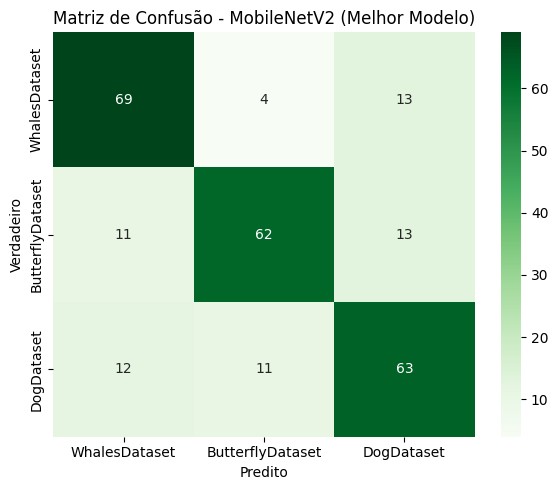

In [11]:
# --- MobileNetV2 (Melhor Modelo) ---
y_pred_best_mobilenet = best_model.predict(test_gen)
y_pred_best_mobilenet_labels = np.argmax(y_pred_best_mobilenet, axis=1)
y_true_mobilenet = test_gen.classes

print("MobileNetV2 (Melhor Modelo):")
print(classification_report(y_true_mobilenet, y_pred_best_mobilenet_labels, target_names=classes))
print("Acurácia:", accuracy_score(y_true_mobilenet, y_pred_best_mobilenet_labels))
print("F1-score:", f1_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted'))
print("Recall:", recall_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted'))
print("Precision:", precision_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted'))

cm_mobilenet = confusion_matrix(y_true_mobilenet, y_pred_best_mobilenet_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mobilenet, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Greens")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - MobileNetV2 (Melhor Modelo)')
plt.tight_layout()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step


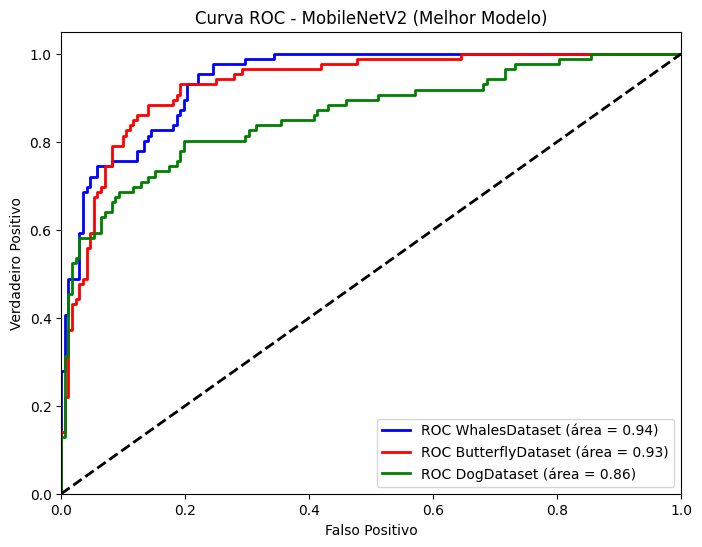

In [12]:
from tensorflow.keras.utils import to_categorical

y_pred_best_mobilenet = best_model.predict(test_gen)
y_pred_best_mobilenet_labels = np.argmax(y_pred_best_mobilenet, axis=1)
y_true_mobilenet = test_gen.classes

y_true_mobilenet_bin = to_categorical(y_true_mobilenet, num_classes=len(classes))
y_score_mobilenet = y_pred_best_mobilenet  

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_mobilenet_bin[:, i], y_score_mobilenet[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {classes[i]} (área = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC - MobileNetV2 (Melhor Modelo)')
plt.legend(loc="lower right")
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step


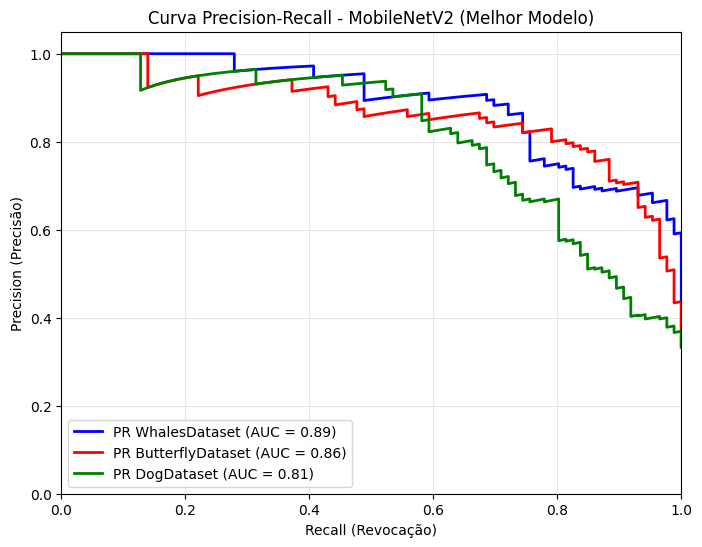


Área sob a curva Precision-Recall (AUC-PR):
WhalesDataset: 0.8899
ButterflyDataset: 0.8646
DogDataset: 0.8128


In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.keras.utils import to_categorical
from itertools import cycle
import matplotlib.pyplot as plt

# Fazer predições (mesmo código da ROC)
y_pred_best_mobilenet = best_model.predict(test_gen)
y_pred_best_mobilenet_labels = np.argmax(y_pred_best_mobilenet, axis=1)
y_true_mobilenet = test_gen.classes

y_true_mobilenet_bin = to_categorical(y_true_mobilenet, num_classes=len(classes))
y_score_mobilenet = y_pred_best_mobilenet

# Calcular Precision-Recall para cada classe
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_true_mobilenet_bin[:, i], y_score_mobilenet[:, i])
    pr_auc[i] = average_precision_score(y_true_mobilenet_bin[:, i], y_score_mobilenet[:, i])

# Plotar a curva Precision-Recall
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'PR {classes[i]} (AUC = {pr_auc[i]:0.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Revocação)')
plt.ylabel('Precision (Precisão)')
plt.title('Curva Precision-Recall - MobileNetV2 (Melhor Modelo)')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

# Mostrar os valores AUC-PR
print("\nÁrea sob a curva Precision-Recall (AUC-PR):")
for i, classe in enumerate(classes):
    print(f"{classe}: {pr_auc[i]:.4f}")

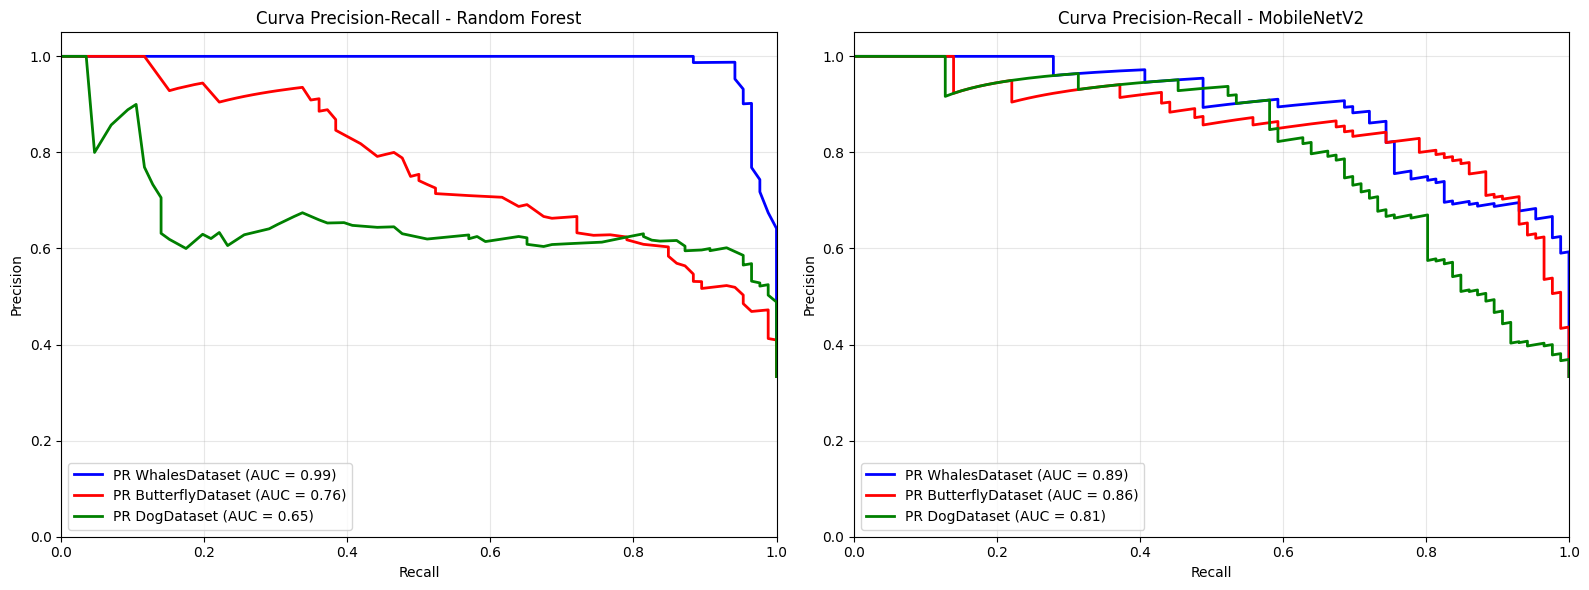

In [15]:
# Criar subplots para comparar os dois modelos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(classes)), colors):
    ax1.plot(recall_rf[i], precision_rf[i], color=color, lw=2,
             label=f'PR {classes[i]} (AUC = {pr_auc_rf[i]:.2f})')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Curva Precision-Recall - Random Forest')
ax1.legend(loc="lower left")
ax1.grid(True, alpha=0.3)

# MobileNetV2
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(classes)), colors):
    ax2.plot(recall[i], precision[i], color=color, lw=2,
             label=f'PR {classes[i]} (AUC = {pr_auc[i]:.2f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall - MobileNetV2')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
import pandas as pd

y_pred_best = best_model_rf.predict(X_test)
y_pred_best_mobilenet = best_model.predict(test_gen)
y_pred_best_mobilenet_labels = np.argmax(y_pred_best_mobilenet, axis=1)
y_true_mobilenet = test_gen.classes

dados = {
    "Modelo": ["Random Forest", "MobileNetV2"],
    "Acurácia": [accuracy_score(y_test, y_pred_best), accuracy_score(y_true_mobilenet, y_pred_best_mobilenet_labels)],
    "F1-score": [f1_score(y_test, y_pred_best, average='weighted'), f1_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted')],
    "Recall": [recall_score(y_test, y_pred_best, average='weighted'), recall_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted')],
    "Precision": [precision_score(y_test, y_pred_best, average='weighted'), precision_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted')]
}
df = pd.DataFrame(dados)
display(df)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step


,Modelo,Acurácia,F1-score,Recall,Precision
0,Random Forest,0.782946,0.782450,0.782946,0.798892
1,MobileNetV2,0.751938,0.752006,0.751938,0.754353


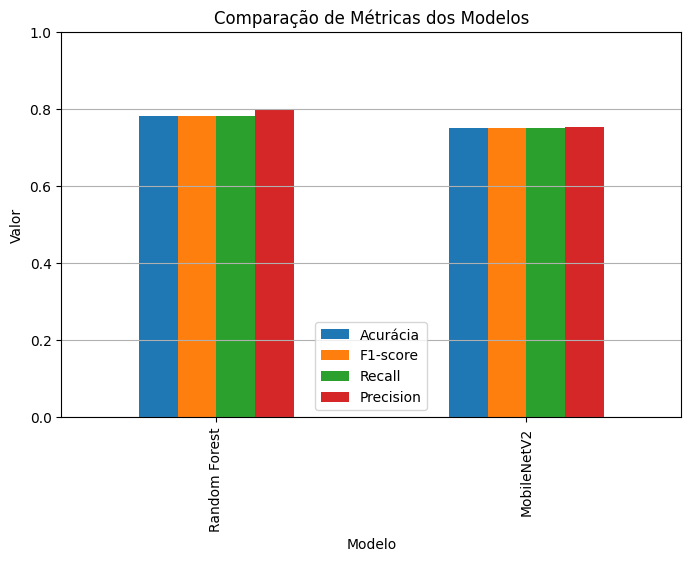

In [17]:
df.set_index("Modelo").plot(kind="bar", figsize=(8,5))
plt.title("Comparação de Métricas dos Modelos")
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()